# Тестовое задание
<br>

### Общее описание
В этом задании Вам необходимо реализовать и обучить алгоритмы DDPG и TD3, а затем сравнить результаты, полученные данными алгоритмами. Тестирование проводится с помощью одной из классических сред LunarLanderContinuous, которая входит в библиотеку OpenAI Gym.<br><br>
При решении задачи крайне приветствуется внесение в алгоритмы специфичных для данной задачи модификаций.

### Критерии оценки

* Задача полностью решена, если агент в среднем достигает 220+ очков
* Задача решена удовлетворительно, если агент в среднем достигает 50+ очков
* Помимо результатов обучения агента, также оценивается качество кода и анализа результатов

In [19]:
import gym
import matplotlib.pyplot as plt
import copy
import random
import numpy as np

# PyTorch
import torch
from torch import nn
from torch import optim
from tqdm.notebook import tqdm

# Устройство, на котором будет работать PyTorch.
device = torch.device('cuda') # Model trains faster in GPU

%matplotlib inline

In [20]:
def save_agent(agent, logger):
    if isinstance(agent, TD3):
        save_paths = [
            f"saved_models/td3_best_weights_actor.pt",
            f"saved_models/td3_best_weights_critic.pt",
            f"saved_models/td3_best_weights_critic2.pt",
            f"saved_models/td3_best_weights_target_actor.pt",
            f"saved_models/td3_best_weights_target_critic.pt",
            f"saved_models/td3_best_weights_target_critic2.pt",
        ]
        save_nets = [
            agent.actor, agent.critic, agent.critic2, agent.target_actor,
            agent.target_critic, agent.target_critic2,
        ]

    elif isinstance(agent, DDPG):
        save_paths = [
            f"saved_models/ddpg_best_weights_actor.pt",
            f"saved_models/ddpg_best_weights_critic.pt",
            f"saved_models/ddpg_best_weights_target_actor.pt",
            f"saved_models/ddpg_best_weights_target_critic.pt",
        ]
        save_nets = [agent.actor, agent.critic, agent.target_actor, agent.target_critic]

    else:
        save_paths = []
        save_nets = []

    for path, net in zip(save_paths, save_nets):
        torch.save(net.state_dict(), path)
        # logger.save(glob_str=path)

In [21]:
#@title Буфер опыта
# Тут ничего менять не нужно

class ExperienceReplay:
    def __init__(self, size=10000):
        self.data = []
        self.max_size = size
        self.i = 0

    def add(self, transition):
        if len(self.data) < self.max_size:
            self.data.append(transition)
        else:
            self.data[self.i] = transition
            self.i = (self.i + 1) % self.max_size

    def sample(self, size):
        batch = random.sample(self.data, size)
        return list(zip(*batch))

In [41]:
#@title Метод build_plot для отрисовки графиков
# Тут ничего менять не нужно

def build_plot(xs, means, stds, labels, figsize=(12, 8)):
    colors = [
        (0.8, 0.0, 0.0),
        (0.0, 0.8, 0.0),
        (0.0, 0.0, 0.8),
        (0.0, 0.5, 0.8)
    ]
    x_min = max([x[0] for x in xs])
    x_max = min([x[-1] for x in xs])
    plt.figure(figsize=figsize)
    plt.plot([x_min, x_max], [50., 50.], color=(0.25, 0.25, 0.25, 0.6), linestyle='-.', label='Minimal solution')
    plt.plot([x_min, x_max], [220., 220.], color=(0.75, 0.75, 0.0, 0.6), linestyle='-.', label='Optimal solution')
    for x, mean, std, label, color in zip(xs, means, stds, labels, colors):
        plt.fill_between(x, mean - 2*std, mean + 2*std, color=color, alpha=0.2)
        plt.plot(x, mean, label=label, color=color)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(0, 350)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [29]:
#@title Методы train и test
# Тут ничего менять не нужно

ACTION_SIZE = 2
STATE_SIZE = 8
ENV_NAME = 'LunarLander-v2'

def test(agent, episodes=10):
    rewards = []
    env = gym.make(ENV_NAME, continuous=True)
    for _ in range(episodes):
        sum_reward = 0
        done, trunc = False, False
        state, _ = env.reset()
        while not (done or trunc):
            state, reward, done, trunc, _ = env.step(agent.get_action(state))
            sum_reward += reward
        rewards.append(sum_reward)
    return np.mean(rewards), np.std(rewards), agent.actor_scheduler.get_last_lr()

def train(agent, timesteps=50000, batch_size=256, buffer_size=50000,
          start_train=10000, test_every=1000, test_count=10, logger=None, action_noise=0.15):
    env = gym.make(ENV_NAME, continuous=True)

    torch.manual_seed(0)
    random.seed(0)

    buffer = ExperienceReplay(buffer_size)

    actor_loss_sum = 0
    critic_loss_sum = 0
    loss_ctn = 0

    max_mean_minus_std = 0

    log_ts = []
    log_mean = []
    log_std = []

    done, trunc = False, False
    state, _ = env.reset()

    rng = tqdm(range(timesteps))
    for t in rng:
        if done or trunc:
            done, trunc = False, False
            state, _ = env.reset()

        state = state

        noise = np.random.randn(ACTION_SIZE) * action_noise * (1 - t / timesteps)
        action = np.clip(agent.get_action(state) + noise, -1, 1)

        next_state, reward, done, trunc, _ = env.step(action)
        buffer.add((state, action, next_state, reward, done, trunc))
        state = next_state

        if t > start_train:
            batch = buffer.sample(batch_size)

            critic_loss, actor_loss = agent.update(batch, t)
            actor_loss_sum += actor_loss
            critic_loss_sum += critic_loss
            loss_ctn += 1

            if t % test_every == 0 or t == timesteps - 1:
                log_ts.append(t)
                mean, std, current_lr = test(agent, test_count)
                if logger is not None:
                    logger.log({
                        'mean': mean, 'std': std, 'step': t, 'cur_lr': current_lr,
                        'critic_loss': critic_loss_sum / loss_ctn, 'actor_loss': actor_loss_sum / loss_ctn,
                    }, step=t)
                    if mean - std > max_mean_minus_std:
                        save_agent(agent, logger)
                log_mean.append(mean)
                log_std.append(std)
                rng.set_postfix_str(f'Mean reward: {mean:.2f}, Critic loss: {(critic_loss_sum / loss_ctn):.2f}, Actor loss: {(actor_loss_sum / loss_ctn):.2f}')
                actor_loss_sum = 0
                critic_loss_sum = 0
                loss_ctn = 0

    return np.array(log_ts), np.array(log_mean), np.array(log_std)

### Задание
Вам нужно заполнить пробелы в коде ниже. Код взаимодействия со средой уже реализован за Вас.

In [30]:
class Actor(nn.Module):
    def __init__(self, state_size: int, action_size: int, hidden_size: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.Mish(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.Mish(inplace=True),
            nn.Linear(hidden_size, action_size),
            nn.Tanh(),
        )

    def forward(self, state: torch.FloatTensor):
        """
        Принимает на вход state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Возвращает объект класса torch.Tensor размерности (batch_size, action_size), который является предсказанным действием агента
        """
        return self.net(state)

In [31]:
class Critic(nn.Module):
    def __init__(self, state_size: int, action_size: int, hidden_size: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size + action_size, hidden_size),
            nn.Mish(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.Mish(inplace=True),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, state: torch.FloatTensor, action: torch.FloatTensor):
        """
        Принимает на вход state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Принимает на вход action, который является объектом класса torch.Tensor и имеет размерность (batch_size, action_size)
        Возвращает объект класса torch.Tensor размерности (batch_size, ), который является оценкой Q-function
        """
        return torch.squeeze(self.net(torch.cat((state, action), 1)))

In [32]:
class DDPG:
    def __init__(self, state_size, action_size, tau=0.001, gamma=0.99, lr=1e-4,
                 adam_eps=1e-8, hidden_size=256, timesteps=1_000_000, max_grad_norm=0.5):
        self.gamma = gamma
        self.tau = tau
        self.max_grad_norm = max_grad_norm

        self.actor = Actor(state_size, action_size, hidden_size)
        self.critic = Critic(state_size, action_size, hidden_size)
        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)

        self.actor.to(device)
        self.target_actor.to(device)
        self.critic.to(device)
        self.target_critic.to(device)

        self.actor_optim = optim.Adam(self.actor.parameters(), lr=lr, eps=adam_eps)
        self.actor_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.actor_optim, timesteps)

        self.critic_optim = optim.Adam(self.critic.parameters(), lr=lr, eps=adam_eps)
        self.critic_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.critic_optim, timesteps)

        self.critic_loss_fn = nn.MSELoss()

    def get_action(self, state: np.ndarray):
        """
        Принимает на вход state, который является объектом класса np.ndarray
        Возвращает action, который является объектом класса np.ndarray
        """
        with torch.no_grad():
            action = self.actor(torch.from_numpy(state).to(device))
        return action.cpu().detach().numpy()

    def compute_actor_loss(self, state):
        """
        Принимает на вход state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Возвращает функцию потерь actor'а loss, которая явлеятся объектом класса torch.Tensor
        """
        state = state.to(device)
        action = self.actor(state)
        loss = -self.critic(state, action)
        return loss.mean()

    def compute_critic_loss(self, state, action, next_state, reward, done, trunc):
        """
        Принимает на вход state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Принимает на вход action, который является объектом класса torch.Tensor и имеет размерность (batch_size, action_size)
        Принимает на вход next_state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Принимает на вход reward, который является объектом класса torch.Tensor и имеет размерность (batch_size, )
        Принимает на вход done, который является объектом класса torch.Tensor и имеет размерность (batch_size, ) и тип bool
        Возвращает функцию потерь critic'а loss, которая явлеятся объектом класса torch.Tensor
        """
        with torch.no_grad():
            estimate: torch.Tensor = reward + self.gamma * self.target_critic(next_state, self.target_actor(next_state)) * (1 - (done & ~trunc).to(torch.float32))
        loss = self.critic_loss_fn(estimate, self.critic(state, action))
        return loss

    def soft_update(self, target_net, source_net):
        """
        Применяет soft update с коэффициентом self.tau обновляя параметры target_net с помощью параметров source_net
        """
        for target_parameter, source_parameter in zip(target_net.parameters(), source_net.parameters()):
            target_parameter.data.mul_(1 - self.tau)
            target_parameter.data.add_(self.tau * source_parameter.data)

    def update(self, batch, current_timestep):
        state, action, next_state, reward, done, trunc = batch
        state = torch.tensor(np.array(state), dtype=torch.float32, device=device)
        next_state = torch.tensor(np.array(next_state), dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device).view(-1)
        done = torch.tensor(done, device=device)
        trunc = torch.tensor(trunc, device=device)
        action = torch.tensor(np.array(action), device=device, dtype=torch.float32)

        actor_loss = self.compute_actor_loss(state)
        self.actor_optim.zero_grad()
        actor_loss.backward()
        nn.utils.clip_grad_norm_([p for g in self.actor_optim.param_groups for p in g['params']], self.max_grad_norm)
        self.actor_optim.step()
        self.actor_scheduler.step(epoch=current_timestep)

        # Actor soft update
        self.soft_update(self.target_actor, self.actor)

        critic_loss = self.compute_critic_loss(state, action, next_state, reward, done, trunc)
        self.critic_optim.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_norm_([p for g in self.critic_optim.param_groups for p in g['params']], self.max_grad_norm)
        self.critic_optim.step()
        self.critic_scheduler.step(epoch=current_timestep)

        # Critic soft update
        self.soft_update(self.target_critic, self.critic)

        return critic_loss.item(), actor_loss.item()

In [33]:
class TD3(DDPG):
    def __init__(self, state_size, action_size, tau=0.001, gamma=0.99, lr=1e-4, policy_freq=3,
                 adam_eps=1e-8, hidden_size=256, timesteps=1_000_000, max_grad_norm=0.5):
        super().__init__(state_size, action_size, tau=tau, gamma=gamma, lr=lr, adam_eps=adam_eps,
                         hidden_size=hidden_size, timesteps=timesteps, max_grad_norm=max_grad_norm)
        self.critic2 = Critic(state_size, action_size, hidden_size)
        self.target_critic2 = copy.deepcopy(self.critic2)

        self.critic2.to(device)
        self.target_critic2.to(device)

        self.critic2_optim = optim.Adam(self.critic2.parameters(), lr=lr, eps=adam_eps)
        self.critic2_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.critic2_optim, timesteps)

        self.policy_freq = policy_freq

    def compute_critic_loss(self, state, action, next_state, reward, done, trunc):
        """
        Принимает на вход state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Принимает на вход action, который является объектом класса torch.Tensor и имеет размерность (batch_size, action_size)
        Принимает на вход next_state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Принимает на вход reward, который является объектом класса torch.Tensor и имеет размерность (batch_size, )
        Принимает на вход done, который является объектом класса torch.Tensor и имеет размерность (batch_size, ) и тип bool
        Возвращает функцию потерь critic'а loss, которая явлеятся объектом класса torch.Tensor
        """
        with torch.no_grad():
            noise = (torch.randn(ACTION_SIZE, dtype=torch.float32, device=device) * 0.25).clamp(-0.3, 0.3)
            noisy_action = (self.target_actor(next_state) + noise).clamp(-1, 1)
            estimate = reward + self.gamma * torch.min(
                self.target_critic(next_state, noisy_action),
                self.target_critic2(next_state, noisy_action),
            ).squeeze() * (1 - (done & ~trunc).to(torch.float32))

        loss = self.critic_loss_fn(self.critic(state, action), estimate) \
               + self.critic_loss_fn(self.critic2(state, action), estimate)

        return loss

    def update(self, batch, current_timestep):
        state, action, next_state, reward, done, trunc = batch

        state = torch.tensor(np.array(state), dtype=torch.float32, device=device)
        next_state = torch.tensor(np.array(next_state), dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device).view(-1)
        done = torch.tensor(done, device=device)
        trunc = torch.tensor(trunc, device=device)
        action = torch.tensor(np.array(action), device=device, dtype=torch.float32)

        actor_loss = torch.zeros(1)
        critics_loss = self.compute_critic_loss(state, action, next_state, reward, done, trunc)

        self.critic_optim.zero_grad()
        self.critic2_optim.zero_grad()
        critics_loss.backward()
        nn.utils.clip_grad_norm_([p for g in self.critic_optim.param_groups for p in g['params']], self.max_grad_norm)
        nn.utils.clip_grad_norm_([p for g in self.critic2_optim.param_groups for p in g['params']], self.max_grad_norm)
        self.critic_optim.step()
        self.critic2_optim.step()
        self.critic_scheduler.step(epoch=current_timestep)
        self.critic2_scheduler.step(epoch=current_timestep)

        if current_timestep % self.policy_freq == 0:
            actor_loss = self.compute_actor_loss(state)
            self.actor_optim.zero_grad()
            actor_loss.backward()
            nn.utils.clip_grad_norm_([p for g in self.actor_optim.param_groups for p in g['params']], self.max_grad_norm)
            self.actor_optim.step()
            self.actor_scheduler.step(epoch=current_timestep)

            # Critics soft update
            self.soft_update(self.target_critic, self.critic)
            self.soft_update(self.target_critic2, self.critic2)

            # Actor soft update
            self.soft_update(self.target_actor, self.actor)

        return critics_loss.item(), actor_loss.item()

### Запуск обучения агента
Не забудьте потьюнить гиперпараметры для лучшего результата!

In [70]:
import wandb
wandb.login()
wandb.init(project='DRL_LunarLanderContinuous-v2')
wandb.config = {
    'model_name': 'DDPG',
    'lr': 0.00025,
    'timesteps': 1_000_000,
    'batch_size': 64,
    'hidden_size': 256,
    'tau': 0.005,
    'gamma': 0.99,
    'start_train': 10000,
    'adam_eps': 1e-7,
    'action_noise': 0.25,
    'max_grad_norm': 0.5,
}
config = wandb.config


In [35]:
xs, means, stds, labels = [], [], [], []

In [72]:
# Train DDPG model
ddpg = DDPG(
    STATE_SIZE, ACTION_SIZE, tau=config['tau'], gamma=config['gamma'], lr=config['lr'],
    adam_eps=config['adam_eps'], hidden_size=config['hidden_size'], timesteps=config['timesteps'],
    max_grad_norm=config['max_grad_norm'],
)
x, mean, std = train(
    ddpg, timesteps=config['timesteps'], test_every=10000, batch_size=config['batch_size'],
    start_train=config['start_train'], buffer_size=50000, test_count=50, logger=wandb,
    action_noise=config['action_noise'],
)

xs.append(x)
means.append(mean)
stds.append(std)
labels.append('DDPG')

final_mean, final_std, _ = test(ddpg, episodes=100)
wandb.log({'mean': final_mean, 'std': final_std, 'step': config['timesteps'], 'cur_lr': 0}, step=config['timesteps'])
print(f'Agent mean score is {final_mean} with std {final_std}')


  0%|          | 0/500000 [00:00<?, ?it/s]

Agent mean score is 260.16829010372624 with std 53.076225486966656


In [ ]:
save_paths = [
    f'saved_models/ddpg_best_weights_actor.pt',
    f'saved_models/ddpg_best_weights_critic.pt',
    f'saved_models/ddpg_best_weights_target_actor.pt',
    f'saved_models/ddpg_best_weights_target_critic.pt',
]
save_nets = [ddpg.actor, ddpg.critic, ddpg.target_actor, ddpg.target_critic]

for path, net in zip(save_paths, save_nets):
    net.load_state_dict(torch.load(path))

best_mean, best_std, _ = test(ddpg, episodes=1000)
print(best_mean, best_std)

In [73]:
wandb.finish()

actor_loss,█▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▇████▃▂▁▂▄▄▅▆▆▇▇▇▇▇████
critic_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅█▇█▁▁▁▂▁▁▁▁▁▁▁▁▁▁
cur_lr,▁
mean,▆▇▇█▅█████████▇▇▇▆▇█▁▄▄▃▄▅▅▆▇▄▇█▇▆▇▆▇▆▇█
std,▆▅▄▁█▂▁▁▂▃▂▁▁▃▄▄▃▄▅▃▂▃▄▁▅▄▆▄▃▇▅▄▅▇▅▆▃▆▄▂
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
actor_loss,-86.0911
critic_loss,202.9585
cur_lr,0
mean,260.16829
std,53.07623


In [10]:
import wandb
wandb.login()
wandb.init(project='DRL_LunarLanderContinuous-v2')
wandb.config = {
    'model_name': 'TD3',
    'lr': 0.00025,
    'timesteps': 1_000_000,
    'batch_size': 64,
    'hidden_size': 256,
    'tau': 0.005,
    'gamma': 0.99,
    'start_train': 20000,
    'adam_eps': 1e-7,
    'action_noise': 0.25,
    'max_grad_norm': 0.5,
    'policy_freq': 3,
}
config = wandb.config

wandb: Currently logged in as: uvd174. Use `wandb login --relogin` to force relogin


In [34]:
# Train TD3 model
td3 = TD3(
    STATE_SIZE, ACTION_SIZE, tau=config['tau'], gamma=config['gamma'], lr=config['lr'],
    adam_eps=config['adam_eps'], hidden_size=config['hidden_size'], timesteps=config['timesteps'],
    max_grad_norm=config['max_grad_norm'], policy_freq=config['policy_freq'],
)
x, mean, std = train(
    td3, timesteps=config['timesteps'], test_every=20000, batch_size=config['batch_size'],
    start_train=config['start_train'], buffer_size=50000, test_count=10, logger=wandb,
    action_noise=config['action_noise'],
)

xs.append(x)
means.append(mean)
stds.append(std)
labels.append('TD3')

final_mean, final_std, _ = test(td3, episodes=100)
print(f'Agent mean score is {final_mean} with std {final_std}')

  0%|          | 0/1000000 [00:00<?, ?it/s]

C:\Users\uvd20\.virtualenvs\SpectralTechnologies_Autumn_2022_test_task\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


NameError: name 'xs' is not defined

In [37]:
wandb.finish()

actor_loss,██▆▅▆▆▆▆▆▆▅▅▄▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▂▂▂▂
critic_loss,▂█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean,▁▇▂▂▃▅▆▆▅▆█▆▇███████████████████████████
std,▂▅▆▄▅▅▅▇█▇▁▇▃▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
actor_loss,-25.26144
critic_loss,67.17352
mean,281.26328
std,18.21445
step,999999


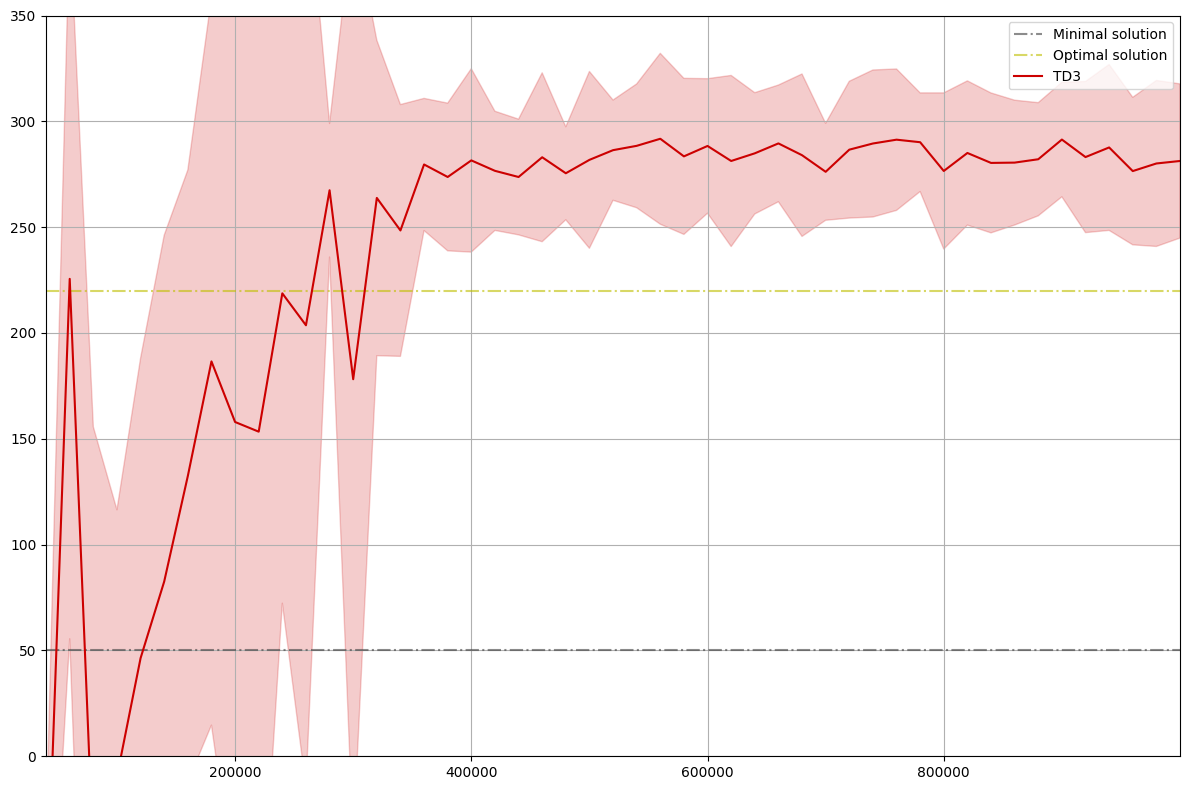

In [42]:
build_plot(xs, means, stds, labels)

In [79]:
# Show the best DDPG results
ddpg = DDPG(STATE_SIZE, ACTION_SIZE)

load_paths = [
    f'saved_models/ddpg_best_weights_actor.pt',
    f'saved_models/ddpg_best_weights_critic.pt',
    f'saved_models/ddpg_best_weights_target_actor.pt',
    f'saved_models/ddpg_best_weights_target_critic.pt',
]
load_nets = [
    ddpg.actor, ddpg.critic,
    ddpg.target_actor, ddpg.target_critic,
]

for path, net in zip(load_paths, load_nets):
    net.load_state_dict(torch.load(path))

best_mean, best_std, _ = test(ddpg, episodes=100)
print(best_mean, best_std)

263.48935154371196 45.08315451583006


In [39]:
# Show the best TD3 results
td3 = TD3(STATE_SIZE, ACTION_SIZE)

load_paths = [
    f'saved_models/td3_best_weights_actor.pt',
    f'saved_models/td3_best_weights_critic.pt',
    f'saved_models/td3_best_weights_critic2.pt',
    f'saved_models/td3_best_weights_target_actor.pt',
    f'saved_models/td3_best_weights_target_critic.pt',
    f'saved_models/td3_best_weights_target_critic2.pt',
]
load_nets = [
    td3.actor, td3.critic, td3.critic2,
    td3.target_actor, td3.target_critic, td3.target_critic2,
]

for path, net in zip(load_paths, load_nets):
    net.load_state_dict(torch.load(path))

best_mean, best_std, _ = test(td3, episodes=100)
print(best_mean, best_std)

282.93172613365607 18.74792110890113


Процесс обучения записывался в wandb: [DRL_LunarLanderContinuous-v2](https://wandb.ai/uvd174/DRL_LunarLanderContinuous-v2)

Обе модели добились желаемого результата.

По графикам обучения видно, что модель, обучавшаяся с помощью TD3 алгоритма, прогрессировала гораздо стабильнее и по итогу достигла более высокого результата. Также стоит отметить, что у TD3 очень маленькая дисперсия при тестировании в отличие от DDPG. Это значит, что при всех возможных начальных положениях агента, TD3 в равной степени хорошо справляется с задачей. DDPG в свою очередь не до конца исследовал окружающую среду и при некоторых начальных состояниях показывает значительно более слабые результаты.